In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kmedoids import KMedoids
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
X = pd.read_csv('../dataset/FM24_engineered_features.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
results = []
Ks = range(2, 11)

for k in Ks:
    kmedoids = KMedoids(n_clusters=k, metric='euclidean', method='alternate')

    kmedoids.fit(X_scaled)
    labels = kmedoids.labels_

    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    results.append({
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db
    })

In [4]:
df_k_results = pd.DataFrame(results)
print("\nCluster quality:")
print(df_k_results)


Cluster quality:
    k  silhouette  davies_bouldin
0   2    0.492711        0.766150
1   3    0.351051        1.278782
2   4    0.238259        1.381066
3   5    0.187594        1.643027
4   6    0.175111        1.804174
5   7    0.165452        1.778708
6   8    0.149802        1.713113
7   9    0.174139        1.710519
8  10    0.122217        1.811742


In [7]:
best_row = df_k_results.sort_values("silhouette", ascending=False).iloc[0]
best_k = int(best_row["k"])
print("\nBest K:", best_k)

best_model = KMedoids(n_clusters=best_k, metric='euclidean', method='alternate')
best_model.fit(X_scaled)

final_labels = best_model.labels_
medoid_indices = best_model.medoid_indices_
medoids = X_scaled[medoid_indices]


Best K: 2


In [9]:
df_engineered = pd.read_csv('../dataset/FM24_engineered_features.csv')
df_meta = pd.read_csv('../dataset/fm24_midfielder_metadata.csv')
df_engineered["Cluster"] = final_labels
df_with_clusters = df_meta.join(df_engineered[["Cluster"]])

In [10]:
df_medoids = df_with_clusters.iloc[medoid_indices].copy()

In [11]:
print("\nRepresentative medoid players per cluster:")
print(df_medoids[["Name", "Club", "Nat", "Age", "CA", "PA", "Cluster"]])

print("\nCluster sizes:")
print(df_engineered["Cluster"].value_counts().sort_index())


Representative medoid players per cluster:
                  Name          Club  Nat  Age   CA   PA  Cluster
1121  Archie Whitehall  Nottm Forest  ENG   17   62  108        0
488        Joan Jordán       Sevilla  ESP   28  129  149        1

Cluster sizes:
Cluster
0    985
1    836
Name: count, dtype: int64


In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

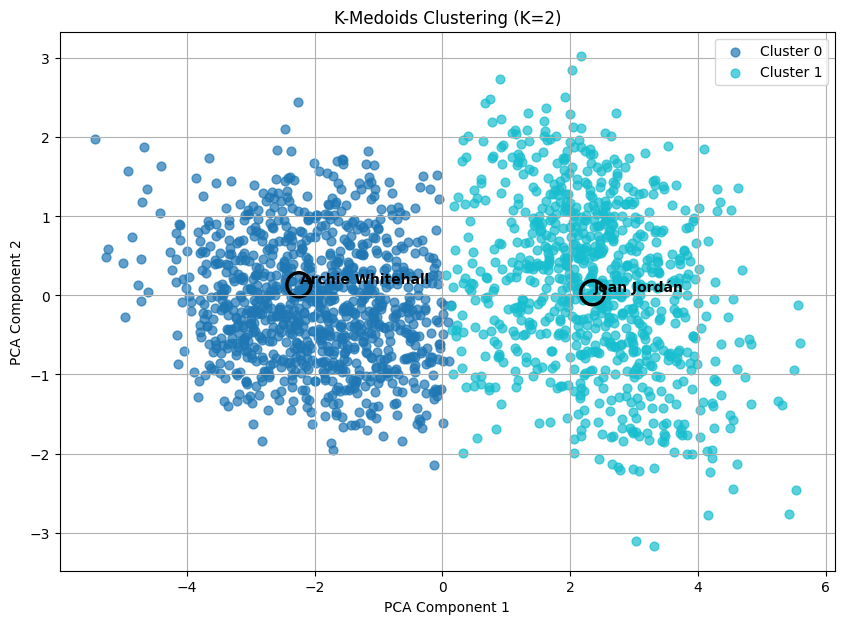

In [14]:
clusters = np.unique(final_labels)

plt.figure(figsize=(10, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    mask = (final_labels == cluster)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        s=40, 
        c=[color], 
        label=f"Cluster {cluster}", 
        alpha=0.70
    )

for i, m in enumerate(medoid_indices):
    plt.scatter(
        X_pca[m, 0], 
        X_pca[m, 1], 
        s=300, 
        edgecolors="black",
        facecolors="none", 
        linewidths=2.5, 
        marker="o"
    )
    # Add player name next to medoid
    name = df_with_clusters.iloc[m]["Name"]
    plt.text(
        X_pca[m, 0]+0.02, 
        X_pca[m, 1]+0.02, 
        name, 
        fontsize=10, 
        fontweight="bold"
    )

plt.title(f'K-Medoids Clustering (K={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()